# **Homework 4 - Movie Recommendation System**

*Group#13*

- **Marco Zimmatore** - [zimmatore.1947442@studenti.uniroma1.it](mailto:zimmatore.1947442@studenti.uniroma1.it)
- **Pierre Risi** - [risi.1914164@studenti.uniroma1.it](mailto:Risi.1914164@studenti.uniroma1.it)
- **Mattia Visciglio** - [visciglio.1914536@studenti.uniroma1.it](mailto:visciglio.1914536@studenti.uniroma1.it)
- **Laura Moreno** - [la.morenorod@gmail.com](mailto:la.morenorod@gmail.com)

___

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import functions
import warnings
warnings.filterwarnings("ignore")

## **1. Recommendation System with LSH**
___

### **1.1 Data preparation** 
Explore the dataset to understand the structure and identify any preprocessing steps needed.

#### **Exploring the Dataset**
We load into two Dataframes the content of the *CSV* files `rating.csv` and `movie.csv`, that will be crucial to build our Reccomender System.

In [2]:
movies_dir = "../movie.csv"
dataset_movies = pd.read_csv(movies_dir)
dataset_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


> Printing the dataframe, we can see that some rows have the expression *(no genres listed)* in the `genres` column

In [3]:
dataset_movies[dataset_movies["genres"] == "(no genres listed)"]

,movieId,title,genres
16574,83773,Away with Words (San tiao ren) (1999),(no genres listed)
16589,83829,Scorpio Rising (1964),(no genres listed)
16764,84768,Glitterbug (1994),(no genres listed)
17080,86493,"Age of the Earth, The (A Idade da Terra) (1980)",(no genres listed)
17243,87061,Trails (Veredas) (1978),(no genres listed)
...,...,...,...
27216,131082,Playground (2009),(no genres listed)
27229,131108,The Fearless Four (1997),(no genres listed)
27258,131166,WWII IN HD (2009),(no genres listed)
27261,131172,Closed Curtain (2013),(no genres listed)


> We replace the string *(no genres listed)* with an empty string

In [4]:
# We use the Pandas built-in function loc to set the values of the column genres that match the search to empty string
dataset_movies.loc[dataset_movies["genres"] == "(no genres listed)", "genres"] = ""
dataset_movies.tail()

,movieId,title,genres
27273,131254,Kein Bund für's Leben (2007),Comedy
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,131258,The Pirates (2014),Adventure
27276,131260,Rentun Ruusu (2001),
27277,131262,Innocence (2014),Adventure|Fantasy|Horror


> For our purposes, it's also useful to load the content of the *Rating* dataset, which will help us to solve the following exercises.

In [5]:
# We open and load in a new Dataframe the content of the CSV file.
rating_dir = '../rating.csv'
dataset_ratings = pd.read_csv(rating_dir)
dataset_ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


We merge the two datasets in order to compute a uniform analysis using the Pandas function `merge()`.
We know that each `movieId` from the *ratings* dataset corresponds to one and only `movieId` value from the *movies* dataset which is a *primary_key*.

- You can notice that we dont specify a Merge type (left, right, ...) because we wanna mantain only the rated movies for our recommender system.

In [6]:
dataset_movies_ratings = pd.merge(dataset_movies, dataset_ratings, on = "movieId")
dataset_movies_ratings.head()

,userId,movieId,rating,timestamp,title,genres
0,1,2,3.5,2005-04-02 23:53:47,Jumanji (1995),Adventure|Children|Fantasy
1,1,29,3.5,2005-04-02 23:31:16,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi
2,1,32,3.5,2005-04-02 23:33:39,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
3,1,47,3.5,2005-04-02 23:32:07,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,3.5,2005-04-02 23:29:40,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


Before going deep with the exercise, we conduct the **Exploratory Data Analysis** to deepen the understanding of the two databases

> We print the shape of the DataFrame 

In [7]:
dataset_movies_ratings.shape

(20000263, 6)


The Shape of the merged DataFrame  mantains the number of rows of the longest between the two DataFrames.

> We print the column's names

In [8]:
list(dataset_movies_ratings.columns)

['userId', 'movieId', 'rating', 'timestamp', 'title', 'genres']

> We check the Data Types of each column

In [9]:
dataset_movies_ratings.dtypes

userId         int64
movieId        int64
rating       float64
timestamp     object
title         object
genres        object
dtype: object

> Seen that the column timestamp is detected as *Object*, we convert it to *timestamp*

In [10]:
dataset_movies_ratings['timestamp'] = pd.to_datetime(dataset_movies_ratings['timestamp'])
dataset_movies_ratings.dtypes

userId                int64
movieId               int64
rating              float64
timestamp    datetime64[ns]
title                object
genres               object
dtype: object

> We check if there are Nan values in the columns

In [11]:
# We filter the columns only for the columns that have at least 1 null value
list(dataset_movies_ratings.columns[dataset_movies_ratings.isnull().sum() > 0])

[]

> We check if there are any duplicates through the function `duplicated()` that returns *True* or *False* if the row is duplicated. Filtering by row, we obtain a DataFrame containing all the duplicated rows

In [12]:
# List of Rows Duplicated
dataset_movies_ratings[dataset_movies_ratings.duplicated()]

,userId,movieId,rating,timestamp,title,genres


There are no duplicates in the DataFrame.

> What's the number of the users who have rated a movie?

In [20]:
dataset_movies_ratings["userId"].nunique()

138493

#### **Tabular Summary**

We calculate statistics like mean, median, minimum through the Pandas function `describe()` and explore how data is distributed.

In [13]:
dataset_movies_ratings.describe()

,userId,movieId,rating,timestamp
count,2.000026e+07,2.000026e+07,2.000026e+07,20000263
mean,6.904587e+04,9.041567e+03,3.525529e+00,2004-11-20 02:32:01.677113984
min,1.000000e+00,1.000000e+00,5.000000e-01,1995-01-09 11:46:44
25%,3.439500e+04,9.020000e+02,3.000000e+00,2000-08-20 18:55:45
50%,6.914100e+04,2.167000e+03,3.500000e+00,2004-12-20 15:18:06
75%,1.036370e+05,4.770000e+03,4.000000e+00,2008-11-02 16:11:57.500000
max,1.384930e+05,1.312620e+05,5.000000e+00,2015-03-31 06:40:02
std,4.003863e+04,1.978948e+04,1.051989e+00,NaN


We can notice that only the Numeric columns are integrated in the summary. The tabular summary of the dataset is pretty useless, because the column `movieId` is a *primary_key* and it's a categorical-like identifier. The column *rating* is the only numeric column where these statistics are actually valuable:

- `mean`: The average rating is 3.53, indicating that users generally rate movies slightly above the midpoint of the 0.5 to 5 rating scale.

- `std`: A standard deviation of 1.05 suggests moderate variability in the ratings.

- `Percentiles`:
    - The median (50%) is 3.5, aligning with the mean.
    - 75% of ratings are below 4, suggesting fewer very high ratings.

#### **Visualization**

The last step of Exploring the Dataset is to visualize the data.


To  visualize the distribution of movie ratings across all users we use a *box plot*. 
A box plot provides a summary of a set of data values through their quartiles, and it can help visualize the spread of the ratings and identify any potential outliers.

C:\Users\Marco\AppData\Local\Temp\ipykernel_29436\3347478301.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='rating', data=dataset_movies_ratings, color='lightgreen', palette='crest')


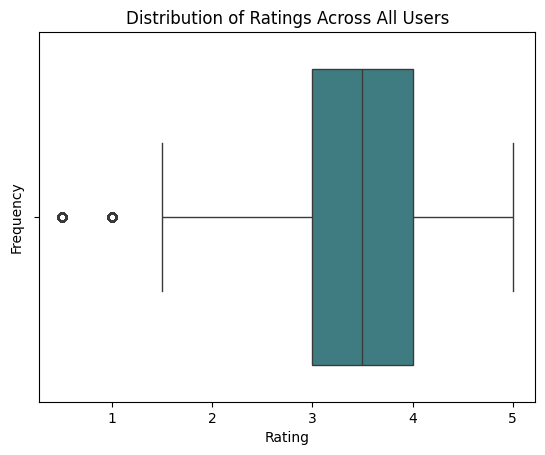

In [19]:
sns.boxplot(x='rating', data=dataset_movies_ratings, color='lightgreen', palette='crest')
plt.title('Distribution of Ratings Across All Users')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show();

> We can notice by the boxplot that the majority of the user have rated movies between 3 and 4, confirming the previous results given by the tabular summary that computed a mean of 3.5. We also mention the presence of some outliers
___

The following *plot* outputs the number of rating over time per each month in every date we find in the dataset. We use the `resample("M", on = "timestamp")` to group data by month using the `timestamp` column and counting all the ratings done in the same month.

C:\Users\Marco\AppData\Local\Temp\ipykernel_29436\217991108.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rating_counts = dataset_movies_ratings.resample('M', on='timestamp').size()


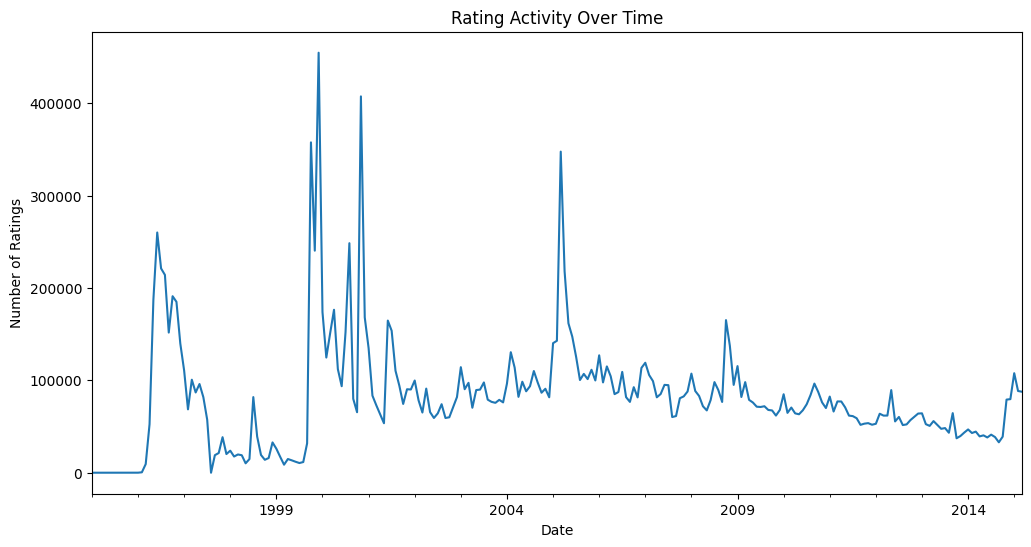

In [22]:
# Resample data by Month and count the number of ratings
rating_counts = dataset_movies_ratings.resample('M', on='timestamp').size()

# Plot time series of rating activity
plt.figure(figsize=(12, 6))
rating_counts.plot()
plt.title('Rating Activity Over Time Every Month')
plt.xlabel('Date')
plt.ylabel('Number of Ratings')
plt.show()


> We see that in the year 2000, we had the most ratings in the dataset, reaching over *400 000* ratings submitted. We have to mention a slow descrease of the ratings aftert the 2005 peaks.
___

In the end, we create an heatmap of the ratings taking into account 20 random users and 20 random movies (for computational issues) through the function `sample()`. We analyse with an *heatmap* the value of the rating done by the user to the movie and we assign a color based on the rating's value.

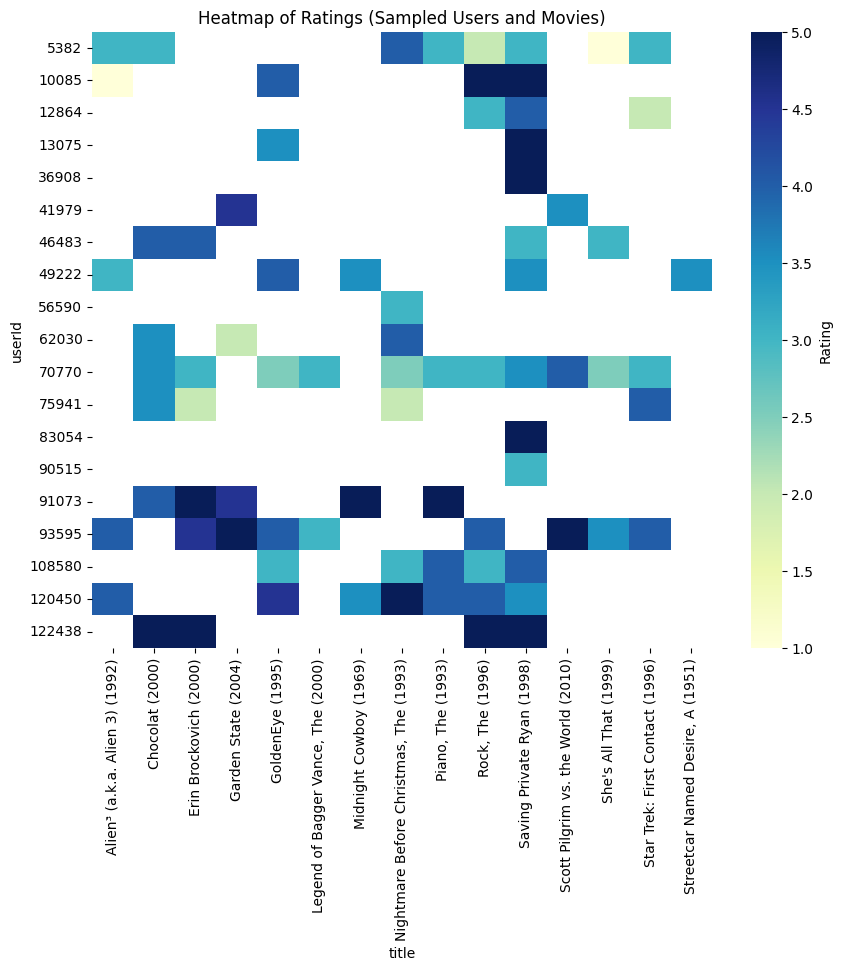

In [29]:
# Sample 1000 random users and 20 random movies
sampled_users = dataset_movies_ratings['userId'].sample(20).unique()
sampled_movies = dataset_movies_ratings['title'].sample(20).unique()

# Create the user-item rating matrix (with NaN for missing ratings)
rating_matrix = dataset_movies_ratings[dataset_movies_ratings['userId'].isin(sampled_users) &
                                        dataset_movies_ratings['title'].isin(sampled_movies)]
rating_matrix = rating_matrix.pivot(index='userId', columns='title', values='rating')

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(rating_matrix, cmap="YlGnBu", fmt='.1f', cbar_kws={'label': 'Rating'})
plt.title('Heatmap of Ratings (Sampled Users and Movies)')
plt.show()


> We notice that darker the colors are for that *movie* (column), and better ratings thay will have from each user (row) 

___

### **1.2 Minhash Signatures**

Using the `userId` and `movieId` columns, implement your own **MinHash function**. This function will hash each user's watched movie list, creating a representation that allows for quick comparisons of user similarities.

In [49]:
import importlib
importlib.reload(functions)

<module 'functions' from 'c:\\Users\\Marco\\Desktop\\Magistrale\\ADM\\ADM-HW4\\ADM-HW4\\functions.py'>

- Before applying the `LSH` algorithm, we have to create the *signature matrix*, which provides a structured way to represent user-item interactions, serving as the foundation for various collaborative filtering and matrix factorization techniques. In our case, we will have matrix where each row represent the unique *movies* and each columns the unique *users*.


**Function** `createBinaryMatrix`:

- Extract unique users and movies:

    - Identify all unique `userIds` and `movieIds` from the dataset.
    - These represent the rows (movies) and columns (users) of the binary matrix.

- Create mappings:
    - Map each userId and movieId to a corresponding index using Python dictionaries.

- Initialize the binary matrix:

    - Construct a 2D numpy array with dimensions [`number of movies`] x [`number of users`].
    - All entries are initialized to 0.

- Populate the matrix:

    - Iterate through each row in the DataFrame.
    - For each (`userId`, `movieId`) pair, set the corresponding matrix cell to 1, indicating interaction, 0 otherwise.

In [11]:
characteristic_matrix = functions.createBinaryMatrix(dataset_movies_ratings)

Now that we have the `characteristic_matrix`, we can compute the MinHash `signature_matrix` through our custom *MinHashFunction*.

- The goal of the **MinHash** is to replace a large set with a smaller "signature" that still preserves the underlying similarity metric.

**Function** `MinHashFunction`:


- Initialize Parameters:

    - `num_movies`: Number of rows in the characteristic matrix.
    - `num_users`: Number of columns in the characteristic matrix.
    - `k`: Total number of rows (used as a prime modulus in hash functions).
    - `num_groups`: Number of row groups, determined by m (rows per group).

- Signature Matrix Initialization:

    - Initialize a signature matrix of size [num_hashes * num_groups, num_users].
    - Set all entries to infinity (np.inf) to later find the minimum hash values.

- Create Random Hash Functions:

    - Generate num_hashes hash functions using the formula $h(x)=(a⋅x+b)%p$, where:
        - `a` and `b` are random coefficients.
        - `p` is the number of rows (`k`).

- Group-Wise Processing:

    - Process rows in groups of size `m` to reduce memory overhead, hence we wanna optimize the MinHash Function.

    - For each group:
        - Extract the relevant rows from the characteristic matrix.

- Compute Row Hashes:

    - For each hash function:
        - Compute hash values for rows in the current group.
        - For each user:
            - Check if the user has interacted with any item in the group (if the column has a 1).
            - Find the minimum hash value among the active rows (`row_hashes` for rows with 1 in the user column).
            - Update the corresponding signature matrix entry with the minimum value.

In [21]:
signature_matrix = functions.MinHashFunction(num_hashes = 2, characteristic_matrix = characteristic_matrix, m = 10)

> Notice that we have chosen $m = 10$ and $num\_ashes = 2$ during the function call

___
- Experiment with different hash functions and threshold values to find the most effective configurations. Report these results.


### **1.3 Locality-Sensitive Hashing (LSH)**
Now that you have generated MinHash user signatures, apply Locality-Sensitive Hashing (LSH) to cluster similar users.

1. **Bucket Creation**: For each user, divide the MinHash signature into bands and hash each band to form buckets. Users with similar bands should fall into the same buckets.
    - **Debugging Tip**: After creating buckets, check a few bucket contents to verify that multiple users are being grouped in the same buckets.


> Since we have built our **MinHash Signature Matrix**, we can apply the *LSH* algorithm in order to classify each user to a bucket so that users that have rated common movies belong to similar buckets.

**Function** `lsh_user_movies`:

- Calculate Rows per Band:

    - The number of rows in each band is calculated by dividing the total number of rows of the signature_matrix (num_hashes * num_movies) by the number of bands (num_bands).

- Loop Over Bands:

    - For each band we identify `start_row` and `end_row` of the signature_matrix belonging to the current band

- Process Each User:
    - For each user we compute *Band Signature*:
        - A tuple called `band_signature` is created from the user's hash values in this band

- Hash into Buckets:
    - Users with the same band_signature are grouped into the same bucket.

In [28]:
buckets = functions.lsh_user_movies(signature_matrix, num_bands = 3)

> `buckets` will contain a dictionary key, value where the key are represented by tuples of hashes of the signature_matrix and their size will be `rows_per_band`, while the value will be the list of userId indexes that belong to that band. 

2. **Query**: For a given user, identify the **two most similar** users based on their bucket placement. If a user doesn’t have any similar users in their bucket, adjust the parameters until similar users are found.




> Now that we have the *buckets* dictionary, retrieving similar users becomes very simple, because they will be in the same bucket of the input user.

**Function** `query_similar_users`:

- We search the most similar users in the same bucket of the `user_index`, defining a Set and discarding the user_index

- Then we compute the **Jaccard Similarity** between the columns of the *signature matrix*, representing the hash_values for each *similar_userId* and we sort the users based on the similarity.

- We return a list of candidate users index


In [29]:
user_index = 1
similar_users = functions.query_similar_users(user_index, buckets, signature_matrix)

3. **Movie Recommendation Logic**:

    - If both similar users have rated a movie, recommend this movie based on the **average rating**.
    
    - If there are no commonly rated movies, recommend the top-rated movies of the most similar user.
    
4. **Final Recommendation**: Provide at most five movies to the user.

> To compute the recommended movies, we will recommend firstly the common movies by the similar users based on aveage rating and then the top-rated ones.

**Function** `recommend_movies`

- Firstly, we add to the list of recommended movies the common movies rated by the similar users that have that highest average ratings.

- If the length of the lsit of recommended movies is not enough (less than *max_recommendation*), we select the highest rated movies by similar users

- We select the most similar user (remember the the list `similar_users` was sorted on similarity)

- We select all the movies rated by this user, sorting them by rating, and add them to the list_of_recommended_movies until its length is equal to *max_recommendation*

In [50]:
user_movie_ratings = dataset_movies_ratings[["userId","movieId", "title", "rating"]]
recommendations = functions.recommend_movies(similar_users, user_movie_ratings)
recommendations

,Movies Reccomended,Rating
0,"Godfather, The (1972)",5.00
1,2001: A Space Odyssey (1968),5.00
2,"Godfather: Part II, The (1974)",5.00
3,"Shawshank Redemption, The (1994)",4.75
4,"Silence of the Lambs, The (1991)",4.75


## **2. Grouping Movies Together!**
___
In this section, you will explore clustering algorithms to group the movies you have based on specific features you choose to consider for them.


### **2.1 Feature Engineering**

As you know, the dataset provided isn’t particularly clean or well-structured to represent the features of the movies. Therefore, your first step is to create a more suitable set of attributes (variables, features, covariates) to represent the movies based on the available information. Here are some variables or features you might consider for clustering:

1. `movieid` id of each movie
2. `genres` list of genres attached to the movie (given that a movie may have several genres, it’s essential to devise a method to accurately represent the genres for each movie)
3. `ratings_avg` the average ratings provided by users for the movie
4. `relevant_genome_tag` the most relevant tag to the movie given in the genome set
5. `common_user_tag` the most common tag given to the movie by the users

In addition to the above features, include **at least three additional** features for clustering.





In [ ]:
new_dataset = dataset_movies_ratings.drop(columns=['userId','timestamp'])
new_order = ['movieId', 'title', 'genres', 'rating']
new_dataset = new_dataset[new_order]
new_dataset

,movieId,title,genres,rating
0,2,Jumanji (1995),Adventure|Children|Fantasy,3.5
1,29,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi,3.5
2,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,3.5
3,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,3.5
4,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,3.5
...,...,...,...,...
20000258,68954,Up (2009),Adventure|Animation|Children|Drama,4.5
20000259,69526,Transformers: Revenge of the Fallen (2009),Action|Adventure|Sci-Fi|IMAX,4.5
20000260,69644,Ice Age: Dawn of the Dinosaurs (2009),Action|Adventure|Animation|Children|Comedy|Rom...,3.0
20000261,70286,District 9 (2009),Mystery|Sci-Fi|Thriller,5.0


In [ ]:

duplicati = new_dataset['title'].duplicated().any()

if duplicati:
    print("There are duplicates titles. Ci sono titoli ripetuti nel DataFrame.")
else:
    print("There are not duplicates titles. Non ci sono titoli ripetuti nel DataFrame.")


There are duplicates titles. Ci sono titoli ripetuti nel DataFrame.


> We create the column `ratings_avg` for the *new_dataset* 

In [ ]:

# Rimuovere le righe dove 'genres' è una stringa vuota o contiene solo spazi
new_dataset = new_dataset[new_dataset['genres'].apply(lambda x: isinstance(x, str) and bool(x.strip()))]


ratings_avg = new_dataset.groupby('title')['rating'].mean()
new_dataset = new_dataset.drop(columns=['rating'])

# we round the ratings_avg one terms after the comma
arrotondo = [round(num, 1) for num in ratings_avg.values]


# we delete the duplicate titles 
new_dataset = new_dataset.drop_duplicates(subset='title', keep='first')
new_dataset['ratings_avg'] = arrotondo
print(new_dataset.shape)
new_dataset.head()


(26487, 4)


,movieId,title,genres,ratings_avg
0,2,Jumanji (1995),Adventure|Children|Fantasy,3.7
1,29,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi,2.8
2,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,2.9
3,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,3.0
4,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,2.0


> check if we eliminate the film how has no genres

In [ ]:
# controllo 
check = new_dataset['genres'].apply(lambda x: isinstance(x, str) and bool(x.strip())).all()
if check:
    print("we eliminate the films how have no genres")
else:
    print("we do not eliminate the films how have no genres")

we eliminate the films how have no genres


> Now we give a mean genre for each film and choose at most 2 words for genre.

In [ ]:
def representative_genre(genres):
    genres = genres.lower()
    genres = genres.split("|")
    if 'children' in genres:
        return 'children'
    if 'fantasy' in genres and 'mystery' in genres:
        return 'mystery'
    if 'action' in genres and 'adventure' in genres:
        return 'action adventure'
    if 'action' in genres and 'fantasy' in genres:
        return 'fantasy action'
    if 'thriller' in genres and 'horror' in genres:
        return 'horror'
    if 'biographical' in genres:
        return 'biographical'
    if 'historical' in genres:
        return 'historical'
    
    # va modificato
    if 'comedy' in genres and 'drama' in genres:
        return 'comedy'  # o 'drama', a seconda della predominanza
    
    return genres[0]  # In caso di conflitto, scegli il primo genere

In [ ]:
new_genres = new_dataset['genres'].apply(lambda x: representative_genre(x))
new_dataset["genres"] = new_genres
new_dataset.head()


,movieId,title,genres,ratings_avg
0,2,Jumanji (1995),children,3.7
1,29,"City of Lost Children, The (Cité des enfants p...",mystery,2.8
2,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),mystery,2.9
3,47,Seven (a.k.a. Se7en) (1995),mystery,3.0
4,50,"Usual Suspects, The (1995)",crime,2.0


In [ ]:
# Control for genres filter
lista = []
for string in new_genres:
    if '|' in string:
        lista.append( False ) 
    lista.append(True)
if all(lista):
    print("We filter all the genres in the dataframe, we have all genres like: thriller or action adventure")
else:
    print("We does not filter all the genres in the dataframe, we still have genres like: adventure|comedy")

We filter all the genres in the dataframe, we have all genres like: thriller or action adventure


> let's see if some genre is empty

In [ ]:
lista = []
for string in new_genres:
    if len(string)== 0:
        lista.append( False ) 
    lista.append(True)
if all(lista):
    print("all clean")
else:
    print("not all clean")

all clean


In [ ]:
# list contais all the filtered genres
new_genres = set(new_genres)
print(new_genres)
print(len(new_genres))
print(type(new_genres))

{'horror', 'war', 'crime', 'animation', 'drama', 'adventure', 'western', 'fantasy', 'documentary', 'musical', 'imax', 'film-noir', 'action adventure', 'children', 'action', 'fantasy action', 'comedy', 'thriller', 'romance', 'mystery', 'sci-fi'}
21
<class 'set'>


> we read the file genome_tags.csv

In [ ]:
new_dataset.head()

,movieId,title,genres,ratings_avg
0,2,Jumanji (1995),children,3.7
1,29,"City of Lost Children, The (Cité des enfants p...",mystery,2.8
2,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),mystery,2.9
3,47,Seven (a.k.a. Se7en) (1995),mystery,3.0
4,50,"Usual Suspects, The (1995)",crime,2.0


In [ ]:
# we read the genome_tags.csv
movie_tag = "archive/genome_tags.csv"
dataset_genome_tags = pd.read_csv(movie_tag)

# remove the empty tags
dataset_genome_tags = dataset_genome_tags[dataset_genome_tags['tag'].apply(lambda x: isinstance(x, str) and bool(x.strip()))]

print(dataset_genome_tags.head(10))
print("new_dataset shape: ",new_dataset.shape)
print("dataset_genome_tags shape:", dataset_genome_tags.shape)

   tagId           tag
0      1           007
1      2  007 (series)
2      3  18th century
3      4         1920s
4      5         1930s
5      6         1950s
6      7         1960s
7      8         1970s
8      9         1980s
9     10  19th century
new_dataset shape:  (26487, 4)
dataset_genome_tags shape: (1128, 2)


In [ ]:
# we read the genome_scores.csv
genome_score = "archive/genome_scores.csv"
dataset_genome_score = pd.read_csv(genome_score)

# remove the empty tags
dataset_genome_score = dataset_genome_score.dropna()

print(dataset_genome_score.head(10))
print("dataset_genome_score shape:", dataset_genome_score.shape)

   movieId  tagId  relevance
0        1      1    0.02500
1        1      2    0.02500
2        1      3    0.05775
3        1      4    0.09675
4        1      5    0.14675
5        1      6    0.21700
6        1      7    0.06700
7        1      8    0.26275
8        1      9    0.26200
9        1     10    0.03200
dataset_genome_score shape: (11709768, 3)


> We create the column `relevant_genome_tag`

In [ ]:
dataset_tag = pd.merge(dataset_genome_score,dataset_genome_tags, on='tagId')
dataset_tag.head(10)

,movieId,tagId,relevance,tag
0,1,1,0.02500,007
1,1,2,0.02500,007 (series)
2,1,3,0.05775,18th century
3,1,4,0.09675,1920s
4,1,5,0.14675,1930s
5,1,6,0.21700,1950s
6,1,7,0.06700,1960s
7,1,8,0.26275,1970s
8,1,9,0.26200,1980s
9,1,10,0.03200,19th century


> for choosing the most relevant tag we took the one with highest relevance

In [ ]:
# we filter dataset_tag to the tag with highest relevance
idx_max_relevance = dataset_tag.groupby('movieId')['relevance'].idxmax()
df_max_relevance = dataset_tag.loc[idx_max_relevance]
# add the relevant_genome_tag column in the new_dataset
new_dataset = pd.merge(new_dataset, df_max_relevance, on='movieId', how='inner')
new_dataset = new_dataset.drop(columns=['tagId'])
new_dataset = new_dataset.drop(columns=['relevance'])
new_dataset = new_dataset.rename(columns={'tag': 'relevant_genome_tag'})
new_dataset.head(10)

,movieId,title,genres,ratings_avg,relevant_genome_tag
0,2,Jumanji (1995),children,3.7,adventure
1,29,"City of Lost Children, The (Cité des enfants p...",mystery,2.8,dark fantasy
2,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),mystery,2.9,future
3,47,Seven (a.k.a. Se7en) (1995),mystery,3.0,serial killer
4,50,"Usual Suspects, The (1995)",crime,2.0,oscar (best supporting actor)
5,112,Rumble in the Bronx (Hont faan kui) (1995),action adventure,3.7,martial arts
6,151,Rob Roy (1995),action,3.0,scotland
7,223,Clerks (1994),comedy,2.2,view askew
8,253,Interview with the Vampire: The Vampire Chroni...,drama,2.3,vampires
9,260,Star Wars: Episode IV - A New Hope (1977),action adventure,2.6,space opera


> Last step: create and add the last column `common_user_tag`

In [ ]:
# we read the tag.csv
tag = "archive/tag.csv"
person_tag = pd.read_csv(tag)

# remove the empty tags
person_tag = person_tag[person_tag['tag'].apply(lambda x: isinstance(x, str) and bool(x.strip()))]
person_tag = person_tag.drop( columns= ['timestamp'])
print(person_tag.head(10))
print("person_tag shape:", person_tag.shape)


   userId  movieId               tag
0      18     4141       Mark Waters
1      65      208         dark hero
2      65      353         dark hero
3      65      521     noir thriller
4      65      592         dark hero
5      65      668         bollywood
6      65      898  screwball comedy
7      65     1248     noir thriller
8      65     1391              mars
9      65     1617          neo-noir
person_tag shape: (465541, 3)


> manca da contare e prende il massimo delle occerrenze per tag rispetto agli user

In [ ]:
# Funzione per selezionare i tagId con il numero massimo di occorrenze per movieId

def get_max_occuring_tags(group):
    # Trova il numero massimo di occorrenze per il movieId
    max_count = group['count'].max()
    # Filtra i tagId che hanno il numero massimo di occorrenze
    max_tags = group[group['count'] == max_count]['tagId'].tolist()
    return max_tags


In [ ]:
# count the occurrences
tag_counts = person_tag.groupby(['movieId', 'tag']).size().reset_index(name='count')
# Trova il tag con il massimo numero di occorrenze per ogni movieId
max_tag_per_movie = tag_counts.loc[tag_counts.groupby('movieId')['count'].idxmax()]

# 2. Ora abbiamo un dataframe con una sola riga per ogni movieId, che contiene il tag con il massimo count
#    Per ogni movieId, viene associato solo il tag con il massimo numero di occorrenze
# 3. Uniamo questo dataframe con il dataframe originale
tag_counts_single_tag = tag_counts.merge(max_tag_per_movie[['movieId', 'tag']], on='movieId', how='left', suffixes=('', '_max'))

# Aggiungiamo solo la colonna del tag massimo
common_user_tag = tag_counts_single_tag[['movieId', 'tag_max']].drop_duplicates()
common_user_tag

,movieId,tag_max
0,1,Pixar
84,2,Robin Williams
119,3,moldy
134,4,characters
138,5,steve martin
...,...,...
200348,131054,dinosaurs
200349,131082,Yoshitomo Nara
200351,131164,Vietnam War
200352,131170,alternate reality


In [ ]:
# uniamo common_uesr_tag nel new_dataset
new_dataset = pd.merge(new_dataset, common_user_tag, on='movieId', how='inner')
new_dataset = new_dataset.rename(columns={'tag_max': 'common_user_tag'})
title_column =  new_dataset[['movieId', 'title']]
new_dataset.head(10)

,movieId,title,genres,ratings_avg,relevant_genome_tag,common_user_tag
0,2,Jumanji (1995),children,3.7,adventure,Robin Williams
1,29,"City of Lost Children, The (Cité des enfants p...",mystery,2.8,dark fantasy,dark
2,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),mystery,2.9,future,time travel
3,47,Seven (a.k.a. Se7en) (1995),mystery,3.0,serial killer,serial killer
4,50,"Usual Suspects, The (1995)",crime,2.0,oscar (best supporting actor),twist ending
5,112,Rumble in the Bronx (Hont faan kui) (1995),action adventure,3.7,martial arts,Jackie Chan
6,151,Rob Roy (1995),action,3.0,scotland,18th century
7,223,Clerks (1994),comedy,2.2,view askew,Kevin Smith
8,253,Interview with the Vampire: The Vampire Chroni...,drama,2.3,vampires,vampires
9,260,Star Wars: Episode IV - A New Hope (1977),action adventure,2.6,space opera,sci-fi


> we create the column `release_year`.

So we split the year from the titles

In [ ]:
import re
def extract_numbers_from_title(title):
    numbers = re.findall(r'\((\d+)\)', title)
    return numbers

title_column['release_year'] = title_column['title'].apply(extract_numbers_from_title)
title_column = title_column.drop( columns= ['title'])
new_dataset = pd.merge(new_dataset, title_column, on='movieId', how='inner')
new_dataset.head(10)

/var/folders/56/h1kd8s5j72v89_fbkl21jmw00000gn/T/ipykernel_2973/2471747969.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  title_column['release_year'] = title_column['title'].apply(extract_numbers_from_title)


,movieId,title,genres,ratings_avg,relevant_genome_tag,common_user_tag,release_year
0,2,Jumanji (1995),children,3.7,adventure,Robin Williams,[1995]
1,29,"City of Lost Children, The (Cité des enfants p...",mystery,2.8,dark fantasy,dark,[1995]
2,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),mystery,2.9,future,time travel,[1995]
3,47,Seven (a.k.a. Se7en) (1995),mystery,3.0,serial killer,serial killer,[1995]
4,50,"Usual Suspects, The (1995)",crime,2.0,oscar (best supporting actor),twist ending,[1995]
5,112,Rumble in the Bronx (Hont faan kui) (1995),action adventure,3.7,martial arts,Jackie Chan,[1995]
6,151,Rob Roy (1995),action,3.0,scotland,18th century,[1995]
7,223,Clerks (1994),comedy,2.2,view askew,Kevin Smith,[1994]
8,253,Interview with the Vampire: The Vampire Chroni...,drama,2.3,vampires,vampires,[1994]
9,260,Star Wars: Episode IV - A New Hope (1977),action adventure,2.6,space opera,sci-fi,[1977]


In [ ]:
def remove_numbers_from_title(title):
    clean_title = re.sub(r'\(\d+\)', '', title)  
    clean_title = re.sub(r'\d+', '', clean_title) 
    return clean_title
new_dataset['title'] = new_dataset['title'].apply(remove_numbers_from_title)
new_dataset.head(10)


,movieId,title,genres,ratings_avg,relevant_genome_tag,common_user_tag,release_year
0,2,Jumanji,children,3.7,adventure,Robin Williams,[1995]
1,29,"City of Lost Children, The (Cité des enfants p...",mystery,2.8,dark fantasy,dark,[1995]
2,32,Twelve Monkeys (a.k.a. Monkeys),mystery,2.9,future,time travel,[1995]
3,47,Seven (a.k.a. Seen),mystery,3.0,serial killer,serial killer,[1995]
4,50,"Usual Suspects, The",crime,2.0,oscar (best supporting actor),twist ending,[1995]
5,112,Rumble in the Bronx (Hont faan kui),action adventure,3.7,martial arts,Jackie Chan,[1995]
6,151,Rob Roy,action,3.0,scotland,18th century,[1995]
7,223,Clerks,comedy,2.2,view askew,Kevin Smith,[1994]
8,253,Interview with the Vampire: The Vampire Chroni...,drama,2.3,vampires,vampires,[1994]
9,260,Star Wars: Episode IV - A New Hope,action adventure,2.6,space opera,sci-fi,[1977]


> we create two columns `imdbId` e `tmdbId`.

In [ ]:
# read the link.csv
links = "archive/link.csv"
link = pd.read_csv(links)
# remove the empty link for both columns
link = link.dropna()
# add them 
new_dataset = pd.merge(new_dataset, link, on='movieId', how='inner')
new_dataset['release_year'] = new_dataset['release_year'].apply(lambda x: int(x[0]))
new_dataset.head(10)


,movieId,title,genres,ratings_avg,relevant_genome_tag,common_user_tag,release_year,imdbId,tmdbId
0,2,Jumanji,children,3.7,adventure,Robin Williams,1995,113497,8844.0
1,29,"City of Lost Children, The (Cité des enfants p...",mystery,2.8,dark fantasy,dark,1995,112682,902.0
2,32,Twelve Monkeys (a.k.a. Monkeys),mystery,2.9,future,time travel,1995,114746,63.0
3,47,Seven (a.k.a. Seen),mystery,3.0,serial killer,serial killer,1995,114369,807.0
4,50,"Usual Suspects, The",crime,2.0,oscar (best supporting actor),twist ending,1995,114814,629.0
5,112,Rumble in the Bronx (Hont faan kui),action adventure,3.7,martial arts,Jackie Chan,1995,113326,33542.0
6,151,Rob Roy,action,3.0,scotland,18th century,1995,114287,11780.0
7,223,Clerks,comedy,2.2,view askew,Kevin Smith,1994,109445,2292.0
8,253,Interview with the Vampire: The Vampire Chroni...,drama,2.3,vampires,vampires,1994,110148,628.0
9,260,Star Wars: Episode IV - A New Hope,action adventure,2.6,space opera,sci-fi,1977,76759,11.0


*Conclusion:*

We have more than 8 features because there were some of them how had more informations, so splitting them we get a bigger view of the dataset

### **2.2 Choose your features (variables)!**

With multiple features available for the movies, you need to consider the following two questions: 
1. Should you normalize the data or leave it as is? 
2. Should you include all these features, or can you reduce the dimensionality of the data?

1. What is the importance of normalizing the data in your analysis, and how does it impact the effectiveness of the clustering algorithms you plan to use?
2. If you find that normalizing the values is beneficial, please proceed to normalize the data. To simplify this task, refer to the scikit-learn package for tools and functions that facilitate data normalization.
3. Could you provide some insights on dimensionality reduction? What techniques would be effective for reducing the number of features in the dataset, and why might this be beneficial for the analysis?
4. If you believe dimensionality reduction would be advantageous, please select a method to reduce the dimensionality of the data.

Normalize datas means: adjusting the values of numeric features so that they fit within a specific range or distribution. That is usefull because usually the dataset contains features that have very different ranges, so when they are normalized the model may learn more effectively because each feature will contribute more evenly to the model’s decision-making process.
While if all your features are on the same scale and in the same range, there is no need to normalize.

Given that our dataset features are not on the same scale so we normalize it. There are 

>In our dataset we have two variables type: numbers and strings. First we normalize the numbres variables using StandardScaler for the `release_year` column because the range is too large. We use Min-Max for `ratings_avg`column because it is a continuous variable in the interval from 0 to 5.

>While for the rest we normilize just `relevant_genome_tag` and `common_user_tag` because the other do not need it as `movieId` and the links columns that represent specific characters. For the normalization we use OneHotEncoding, that transforms each category of a variable into a new column, where each column represents a category and contains values ​​of 0 or 1.

Applay StandardScaler to `release_year`

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Supponiamo che 'new_dataset' sia il tuo dataframe originale
df_copy = new_dataset.copy()

# Preprocessing numerico: Applichiamo StandardScaler solo alla colonna 'release_year'
numerical_features = ['release_year']
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Gestione dei valori mancanti
    ('scaler', StandardScaler())  # Standardizzazione solo per 'release_year'
])

# Preprocessing: Creiamo il trasformatore che applica StandardScaler solo a 'release_year'
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features)
    ],
    # La parte 'remainder' mantiene inalterate le altre colonne che non sono numeriche
    remainder='passthrough'
)

# Applica il preprocessing ai dati
X = preprocessor.fit_transform(df_copy)

# Crea un DataFrame con i dati trasformati
# Otteniamo i nomi delle colonne trasformate
# `preprocessor` trasforma solo 'release_year', quindi dobbiamo aggiungere il nome di questa colonna
# Le altre colonne (non numeriche) rimarranno invariabili
columns = numerical_features + [col for col in df_copy.columns if col not in numerical_features]

# Creiamo il DataFrame con i dati trasformati
df_copy = pd.DataFrame(X, columns=columns)

# Visualizza le prime 10 righe per controllo
df_copy.head(10)


,release_year,movieId,title,genres,ratings_avg,relevant_genome_tag,common_user_tag,imdbId,tmdbId
0,0.133841,2,Jumanji,children,3.7,adventure,Robin Williams,113497,8844.0
1,0.133841,29,"City of Lost Children, The (Cité des enfants p...",mystery,2.8,dark fantasy,dark,112682,902.0
2,0.133841,32,Twelve Monkeys (a.k.a. Monkeys),mystery,2.9,future,time travel,114746,63.0
3,0.133841,47,Seven (a.k.a. Seen),mystery,3.0,serial killer,serial killer,114369,807.0
4,0.133841,50,"Usual Suspects, The",crime,2.0,oscar (best supporting actor),twist ending,114814,629.0
5,0.133841,112,Rumble in the Bronx (Hont faan kui),action adventure,3.7,martial arts,Jackie Chan,113326,33542.0
6,0.133841,151,Rob Roy,action,3.0,scotland,18th century,114287,11780.0
7,0.092527,223,Clerks,comedy,2.2,view askew,Kevin Smith,109445,2292.0
8,0.092527,253,Interview with the Vampire: The Vampire Chroni...,drama,2.3,vampires,vampires,110148,628.0
9,-0.609811,260,Star Wars: Episode IV - A New Hope,action adventure,2.6,space opera,sci-fi,76759,11.0


Applay Min-Max to `ratings_avg`

In [ ]:
# columns to applay Min-Max
numerical_features = ['ratings_avg']
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Gestione dei valori mancanti
    ('scaler', MinMaxScaler())  # Standardizzazione solo per 'release_year'
])
preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, numerical_features)],remainder='passthrough')
X = preprocessor.fit_transform(df_copy)
columns = numerical_features + [col for col in df_copy.columns if col not in numerical_features]
df_copy = pd.DataFrame(X, columns=columns)
df_copy.head(10)


,ratings_avg,release_year,movieId,title,genres,relevant_genome_tag,common_user_tag,imdbId,tmdbId
0,0.711111,0.133841,2,Jumanji,children,adventure,Robin Williams,113497,8844.0
1,0.511111,0.133841,29,"City of Lost Children, The (Cité des enfants p...",mystery,dark fantasy,dark,112682,902.0
2,0.533333,0.133841,32,Twelve Monkeys (a.k.a. Monkeys),mystery,future,time travel,114746,63.0
3,0.555556,0.133841,47,Seven (a.k.a. Seen),mystery,serial killer,serial killer,114369,807.0
4,0.333333,0.133841,50,"Usual Suspects, The",crime,oscar (best supporting actor),twist ending,114814,629.0
5,0.711111,0.133841,112,Rumble in the Bronx (Hont faan kui),action adventure,martial arts,Jackie Chan,113326,33542.0
6,0.555556,0.133841,151,Rob Roy,action,scotland,18th century,114287,11780.0
7,0.377778,0.092527,223,Clerks,comedy,view askew,Kevin Smith,109445,2292.0
8,0.4,0.092527,253,Interview with the Vampire: The Vampire Chroni...,drama,vampires,vampires,110148,628.0
9,0.466667,-0.609811,260,Star Wars: Episode IV - A New Hope,action adventure,space opera,sci-fi,76759,11.0


Applay the normalization for the alphabetical columns

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# columns to applay OneHotEncoding
categorical_features = ['relevant_genome_tag', 'common_user_tag']
# we create the transformer for categorical_features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Gestione dei valori mancanti
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))  # OneHotEncoder
])
# create ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'  # Le altre colonne rimangono inalterate
)
# applay preprocessing at the dataset
X = preprocessor.fit_transform(df_copy)
# we get the column names create by OneHotEncoder
ohe_columns = preprocessor.transformers_[0][1].named_steps['onehot'].get_feature_names_out(categorical_features)
# joint the new columns names with the not modify columns
columns = list(ohe_columns) + [col for col in df_copy.columns if col not in categorical_features]
# upgrade a new dataframe 
df_trasformed = pd.DataFrame(X, columns=columns)
df_trasformed.head(10)


,relevant_genome_tag_007,relevant_genome_tag_007 (series),relevant_genome_tag_18th century,relevant_genome_tag_1930s,relevant_genome_tag_1960s,relevant_genome_tag_1980s,relevant_genome_tag_70mm,relevant_genome_tag_80s,relevant_genome_tag_aardman studios,relevant_genome_tag_abortion,...,common_user_tag_zombie,common_user_tag_zombies,common_user_tag_Éva Gárdos,ratings_avg,release_year,movieId,title,genres,imdbId,tmdbId
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.711111,0.133841,2,Jumanji,children,113497,8844.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.511111,0.133841,29,"City of Lost Children, The (Cité des enfants p...",mystery,112682,902.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.533333,0.133841,32,Twelve Monkeys (a.k.a. Monkeys),mystery,114746,63.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.555556,0.133841,47,Seven (a.k.a. Seen),mystery,114369,807.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.333333,0.133841,50,"Usual Suspects, The",crime,114814,629.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.711111,0.133841,112,Rumble in the Bronx (Hont faan kui),action adventure,113326,33542.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.555556,0.133841,151,Rob Roy,action,114287,11780.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.377778,0.092527,223,Clerks,comedy,109445,2292.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.4,0.092527,253,Interview with the Vampire: The Vampire Chroni...,drama,110148,628.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.466667,-0.609811,260,Star Wars: Episode IV - A New Hope,action adventure,76759,11.0


> Reducing features

`DA QUI IN POI VA RIVISTO MA ALMENO DO UN IDEA DI COSA FARO`

`PER FARE QUESTO VANNO TRASFORMATI I TESTI IN NUMERI PER LE COLONNE CHE POSSONO CIOE QUELLE DI SOPRA A CUI ABBIAMO APPLICATO COSE. E SOLO SU QUELLE SPECIFICHE COLONNE ANDRA POI APPLICATO IL CODICE CHE SEGUE COSI DA RIDURRE I FEATURES`

Immagina di avere un dataset con molte variabili, e vuoi ridurre la dimensionalità per applicare un algoritmo di clustering come KMeans: lo riduco a tre features:	movieId,	genres and ratings_avg.

In [ ]:
# create the dataset for the features reduction 
# to df_trasformed we remove some columns 
# we let there just the 4 normalizated columns 
df_trasformed.drop(columns=['title', 'genres','imdbId','tmdbId'], inplace=True) 
df_trasformed.head(10)

,relevant_genome_tag_007,relevant_genome_tag_007 (series),relevant_genome_tag_18th century,relevant_genome_tag_1930s,relevant_genome_tag_1960s,relevant_genome_tag_1980s,relevant_genome_tag_70mm,relevant_genome_tag_80s,relevant_genome_tag_aardman studios,relevant_genome_tag_abortion,...,common_user_tag_writers,common_user_tag_wrongly accused,common_user_tag_wuxia,common_user_tag_youtube,common_user_tag_zombie,common_user_tag_zombies,common_user_tag_Éva Gárdos,ratings_avg,release_year,movieId
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.711111,0.133841,2
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.511111,0.133841,29
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.533333,0.133841,32
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.555556,0.133841,47
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.133841,50
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.711111,0.133841,112
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.555556,0.133841,151
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.377778,0.092527,223
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.092527,253
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.466667,-0.609811,260


In [ ]:
# we save for later the movieId column ù
movie_column = df_trasformed['movieId']
print(type(movie_column))
movie_column.head(10)

<class 'pandas.core.series.Series'>


0      2
1     29
2     32
3     47
4     50
5    112
6    151
7    223
8    253
9    260
Name: movieId, dtype: object

In [ ]:
# apply the PCA for just the columns `relevant_genome_tag` and `relevant_genome_tag`
 
lavoro = df_trasformed.copy()
lavoro = lavoro.drop(columns=['ratings_avg', 'release_year','movieId']) 
print(type(lavoro))
lavoro.head(5)

<class 'pandas.core.frame.DataFrame'>


,relevant_genome_tag_007,relevant_genome_tag_007 (series),relevant_genome_tag_18th century,relevant_genome_tag_1930s,relevant_genome_tag_1960s,relevant_genome_tag_1980s,relevant_genome_tag_70mm,relevant_genome_tag_80s,relevant_genome_tag_aardman studios,relevant_genome_tag_abortion,...,common_user_tag_working class,common_user_tag_workplace,common_user_tag_writer,common_user_tag_writers,common_user_tag_wrongly accused,common_user_tag_wuxia,common_user_tag_youtube,common_user_tag_zombie,common_user_tag_zombies,common_user_tag_Éva Gárdos
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Esempio di Codice per Scegliere il Numero di Componenti con PCA:

Varianza spiegata da ciascuna componente principale: [1.41021824e-02 1.32067197e-02 1.26522283e-02 ... 4.91608271e-35
 2.72102750e-35 8.11537968e-37]
Varianza cumulativa: [0.01410218 0.0273089  0.03996113 ... 1.         1.         1.        ]


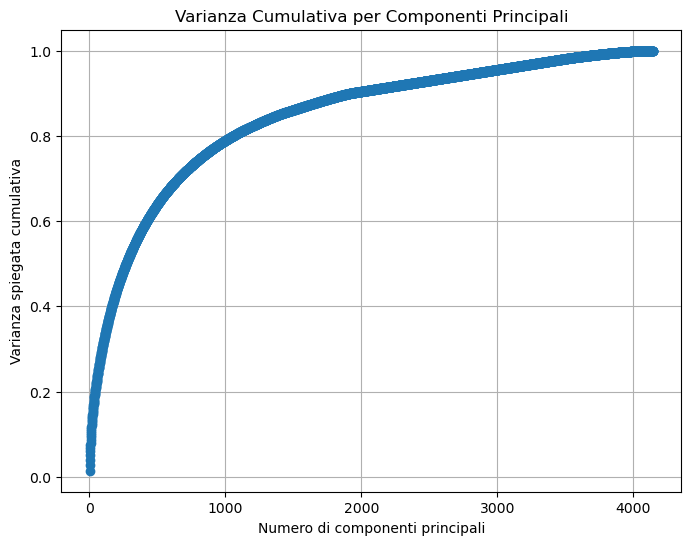

Numero di componenti per spiegare almeno il 90% della varianza: 1920
Shape del dataframe PCA: (9804, 1920)


,relevant_genome_tag_007,relevant_genome_tag_007 (series),relevant_genome_tag_18th century,relevant_genome_tag_1930s,relevant_genome_tag_1960s,relevant_genome_tag_1980s,relevant_genome_tag_70mm,relevant_genome_tag_80s,relevant_genome_tag_aardman studios,relevant_genome_tag_abortion,...,common_user_tag_Humphrey Bogart,common_user_tag_Hunter S. Thompson,common_user_tag_IMAX 3-D,common_user_tag_IMAX DMR 3-D,common_user_tag_INNOCENCE LOST,common_user_tag_Ian McKellen,common_user_tag_Ian Mckellen,common_user_tag_Ice Cube,common_user_tag_Iceland,common_user_tag_Ida Lupino
0,0.000993,-0.035717,-0.001100,-0.029955,-0.017098,-0.006172,-0.018529,-0.000887,-0.020958,-0.007657,...,0.000736,0.000386,0.000599,-0.000630,0.000402,-0.000233,0.000282,0.000297,-0.000662,0.000292
1,-0.005061,-0.035886,-0.001280,-0.030568,-0.009561,-0.006906,-0.015012,0.005328,-0.013333,-0.011144,...,-0.000965,-0.000531,-0.001079,0.001174,0.002283,-0.000770,-0.000872,-0.000728,0.001207,-0.000419
2,-0.002893,-0.045137,-0.009005,-0.037148,-0.020833,-0.012677,-0.014682,-0.005357,-0.031361,-0.009403,...,0.001660,0.001178,-0.000496,0.000413,0.000781,-0.000805,-0.000281,-0.000271,0.001435,0.002207
3,-0.002772,-0.047381,-0.002277,-0.038644,-0.015051,-0.005085,-0.013916,0.029125,-0.001093,-0.033826,...,0.000379,-0.000061,0.000214,-0.000425,0.000175,0.000158,-0.000196,0.000319,-0.000666,0.000287
4,-0.003113,-0.044079,-0.002037,-0.035251,-0.020017,-0.008312,-0.023500,-0.000960,-0.026713,-0.009742,...,0.000528,-0.000566,0.003651,-0.001078,0.000727,-0.001097,0.000431,0.000392,0.001687,-0.001447


In [ ]:
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt

# Supponiamo che df_scaled sia il tuo dataset già normalizzato o standardizzato

# Applica PCA senza specificare il numero di componenti (PCA calcolerà tutte le componenti)
pca = PCA()
pca.fit(lavoro)

# Mostra la varianza spiegata da ciascuna componente
explained_variance = pca.explained_variance_ratio_
print("Varianza spiegata da ciascuna componente principale:", explained_variance)

# Mostra la varianza cumulativa per decidere quante componenti scegliere
cumulative_variance = explained_variance.cumsum()
print("Varianza cumulativa:", cumulative_variance)

# Plot della varianza cumulativa
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Numero di componenti principali')
plt.ylabel('Varianza spiegata cumulativa')
plt.title('Varianza Cumulativa per Componenti Principali')
plt.grid(True)
plt.show()

# Scegliamo il numero di componenti che spiegano almeno il 90% della varianza
n_components = (cumulative_variance >= 0.90).argmax() + 1
print(f"Numero di componenti per spiegare almeno il 90% della varianza: {n_components}")

# Applichiamo PCA con il numero di componenti scelto
pca = PCA(n_components=n_components)
df_pca = pca.fit_transform(lavoro)

# Crea un DataFrame con i risultati della PCA e assegna i nomi delle componenti principali come colonne
pca_columns = [f'PC{i+1}' for i in range(df_pca.shape[1])]  # Assegna "PC1", "PC2", etc.
df_pca = pd.DataFrame(df_pca, columns=pca_columns)

original_columns = lavoro.columns[:n_components]
# Rinomina le colonne del DataFrame ridotto per riflettere i nomi delle colonne originali
df_pca.columns = original_columns

# Mostra la forma e le prime righe del nuovo dataframe
print(f"Shape del dataframe PCA: {df_pca.shape}")
df_pca.head(5)

### **2.3 Clustering**

Now that you have prepared the data, you can create the clusters.


1. How can you determine the optimal number of clusters for your data? Please use at least two methods and provide their results.


1. Elbow Method


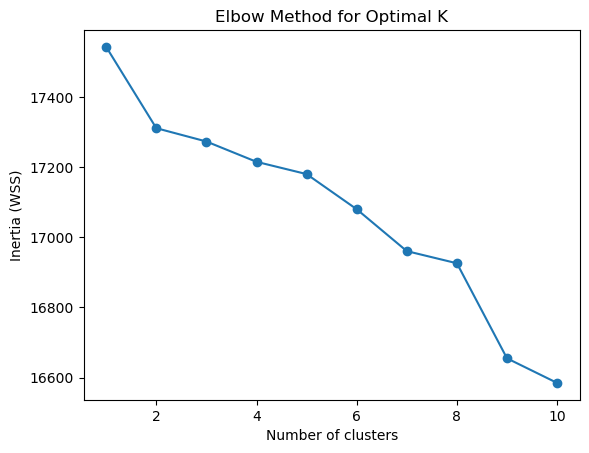

In [ ]:
from sklearn.cluster import KMeans


# Assume X is your dataset
inertia = []
for k in range(1, 11):  # Test from 1 to 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_pca)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow graph
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (WSS)')
plt.title('Elbow Method for Optimal K')
plt.show()

2. Silhouette Score

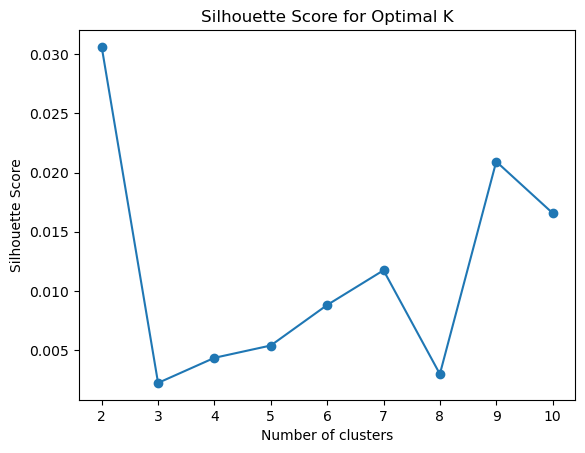

In [ ]:
from sklearn.metrics import silhouette_score
sil_scores = []
for k in range(2, 11):  # Starting from 2 because silhouette score requires at least 2 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_pca)
    score = silhouette_score(df_pca, kmeans.labels_)
    sil_scores.append(score)

# Plotting the Silhouette Scores
plt.plot(range(2, 11), sil_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')
plt.show()

3. Gap Statistic
    
il punto 3 non ha codice ma solo parole le incollo

The Gap Statistic compares the performance of your clustering against a random clustering. It measures the gap between the clustering performance of your data and a random dataset generated from a uniform distribution. The optimal number of clusters is the value of K that maximizes the gap.

Steps:
Compute the clustering performance for your dataset and compare it to the performance on a reference dataset (random uniform distribution).
The gap statistic measures the difference in performance between your data and the random dataset.
The optimal K is the value where the gap is the largest.
There is no built-in function for the Gap Statistic in scikit-learn, but it can be implemented using libraries like gap-statistic or using the pyclustertend package.

4. Davies-Bouldin Index

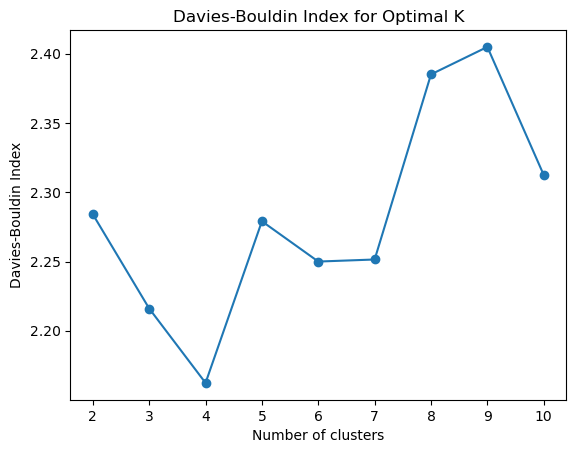

In [ ]:
from sklearn.metrics import davies_bouldin_score
db_scores = []
for k in range(2, 11):  # Starting from 2 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_pca)
    db_score = davies_bouldin_score(df_pca, kmeans.labels_)
    db_scores.append(db_score)
# Plotting Davies-Bouldin Index
plt.plot(range(2, 11), db_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index for Optimal K')
plt.show()


5. Cross-Validation (for Clustering with Supervision)


If you have some labeled data or you are interested in supervised clustering, you can use cross-validation to assess how well your clustering solution generalizes to unseen data. For unsupervised clustering, however, this method is typically not applicable directly.

6. BIC / AIC (for Gaussian Mixture Models)

If you are using Gaussian Mixture Models (GMM) for clustering (instead of K-means), you can use the Bayesian Information Criterion (BIC) or Akaike Information Criterion (AIC)

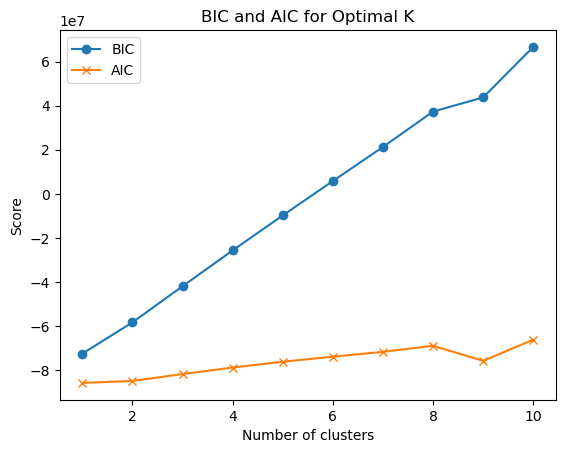

In [ ]:
from sklearn.mixture import GaussianMixture
bic_scores = []
aic_scores = []
for k in range(1, 11):
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(df_pca)
    bic_scores.append(gmm.bic(df_pca))
    aic_scores.append(gmm.aic(df_pca))
# Plot BIC and AIC scores
plt.plot(range(1, 11), bic_scores, label='BIC', marker='o')
plt.plot(range(1, 11), aic_scores, label='AIC', marker='x')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.title('BIC and AIC for Optimal K')
plt.legend()
plt.show()


7. Visual Inspection

For low-dimensional data (e.g., data with 2 or 3 features),

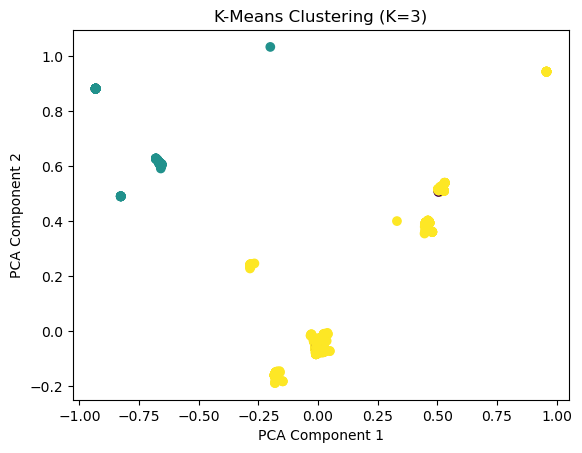

In [ ]:
from sklearn.decomposition import PCA
# Reduce dimensions to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_pca)
# Perform K-means clustering for a specific K (e.g., K=3)
kmeans = KMeans(n_clusters=3)
labels = kmeans.fit_predict(df_pca)
# Plot the 2D projection with cluster labels
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-Means Clustering (K=3)')
plt.show()


2. Implement the K-means clustering algorithm (not K-means++) through MapReduce. We request that you develop the algorithm from scratch based on what you've learned in class and run the algorithm on your data.


from the Elbow Method we notice that the optimal number of cluster is 7 because it is the point where the inertia ends to decrease and starts to increase

In [ ]:
# uniamo il nome dei film a df_pca 
df_pca.insert(loc=0, column='movieId', value=movie_column, allow_duplicates=False)
df_pca.head(8)


,movieId,relevant_genome_tag_007,relevant_genome_tag_007 (series),relevant_genome_tag_18th century,relevant_genome_tag_1930s,relevant_genome_tag_1960s,relevant_genome_tag_1980s,relevant_genome_tag_70mm,relevant_genome_tag_80s,relevant_genome_tag_aardman studios,...,common_user_tag_Humphrey Bogart,common_user_tag_Hunter S. Thompson,common_user_tag_IMAX 3-D,common_user_tag_IMAX DMR 3-D,common_user_tag_INNOCENCE LOST,common_user_tag_Ian McKellen,common_user_tag_Ian Mckellen,common_user_tag_Ice Cube,common_user_tag_Iceland,common_user_tag_Ida Lupino
0,2,0.000993,-0.035717,-0.001100,-0.029955,-0.017098,-0.006172,-0.018529,-0.000887,-0.020958,...,0.000736,0.000386,0.000599,-0.000630,0.000402,-0.000233,0.000282,0.000297,-0.000662,0.000292
1,29,-0.005061,-0.035886,-0.001280,-0.030568,-0.009561,-0.006906,-0.015012,0.005328,-0.013333,...,-0.000965,-0.000531,-0.001079,0.001174,0.002283,-0.000770,-0.000872,-0.000728,0.001207,-0.000419
2,32,-0.002893,-0.045137,-0.009005,-0.037148,-0.020833,-0.012677,-0.014682,-0.005357,-0.031361,...,0.001660,0.001178,-0.000496,0.000413,0.000781,-0.000805,-0.000281,-0.000271,0.001435,0.002207
3,47,-0.002772,-0.047381,-0.002277,-0.038644,-0.015051,-0.005085,-0.013916,0.029125,-0.001093,...,0.000379,-0.000061,0.000214,-0.000425,0.000175,0.000158,-0.000196,0.000319,-0.000666,0.000287
4,50,-0.003113,-0.044079,-0.002037,-0.035251,-0.020017,-0.008312,-0.023500,-0.000960,-0.026713,...,0.000528,-0.000566,0.003651,-0.001078,0.000727,-0.001097,0.000431,0.000392,0.001687,-0.001447
5,112,-0.002151,-0.053376,0.002208,-0.037734,-0.031111,-0.016709,-0.048392,0.002245,-0.061437,...,-0.000229,0.000830,0.000116,-0.000547,0.000113,0.000690,-0.000078,-0.000530,-0.000257,0.000274
6,151,-0.004078,-0.036685,-0.004496,-0.028000,-0.013673,-0.005135,-0.014642,-0.000797,-0.016135,...,-0.003484,-0.000044,0.003378,-0.000242,0.000650,0.001195,-0.000608,0.001767,-0.001669,-0.000011
7,223,-0.004314,-0.038841,-0.004773,-0.029853,-0.014920,-0.005827,-0.016439,-0.001320,-0.017853,...,0.000044,0.000110,-0.000112,0.000092,-0.000040,-0.000171,-0.000095,0.000155,0.000050,-0.000062


In [ ]:

# Funzione per calcolare la distanza Euclidea tra due punti
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

# Funzione per inizializzare i centroidi utilizzando K-means++
def kmeans_plus_plus_init(df, k):
    # Seleziona il primo centroide casualmente
    centroids = [df.sample(n=1).values[0]]
    
    while len(centroids) < k:
        # Calcola la distanza di ogni punto dai centroidi già selezionati
        distances = np.array([min([euclidean_distance(x, c) for c in centroids]) for x in df.values])
        
        # Calcola la probabilità di selezionare un punto come centroide, proporzionale al quadrato della distanza minima
        prob = distances ** 2
        prob = prob / prob.sum()  # Normalizza la probabilità
        
        # Seleziona il nuovo centroide in base alla probabilità calcolata
        new_centroid = df.sample(n=1, weights=prob).values[0]
        centroids.append(new_centroid)
    
    return np.array(centroids)

# Funzione per assegnare ogni punto al centroide più vicino (fase Map)
def map_points_to_centroids(df, centroids):
    mapped_points = []
    
    for point in df.values:
        # Calcola la distanza tra il punto e tutti i centroidi
        distances = [euclidean_distance(point, centroid) for centroid in centroids]
        
        # Trova il centroide più vicino
        closest_centroid = np.argmin(distances)
        
        # Aggiungi la coppia (centroide, punto) alla lista
        mapped_points.append((closest_centroid, point))
    
    return mapped_points

# Funzione per calcolare i nuovi centroidi (fase Reduce)
def reduce_to_new_centroids(mapped_points, k):
    new_centroids = []
    
    for i in range(k):
        # Estrai i punti assegnati a ciascun centroide
        points_assigned = [point for centroid_idx, point in mapped_points if centroid_idx == i]
        
        # Calcola la media dei punti per ottenere il nuovo centroide
        if len(points_assigned) > 0:
            new_centroid = np.mean(points_assigned, axis=0)
        else:
            new_centroid = np.zeros(df.shape[1])  # Se nessun punto è assegnato, usa un centroide nullo
        new_centroids.append(new_centroid)
    
    return np.array(new_centroids)

# Funzione principale che esegue K-means++ con MapReduce
def kmeans_plus_plus(df, k, max_iters=100):
    # Inizializza i centroidi con K-means++
    centroids = kmeans_plus_plus_init(df, k)
    
    for i in range(max_iters):
        # Fase Map: Assegna ogni punto al centroide più vicino
        mapped_points = map_points_to_centroids(df, centroids)
        
        # Fase Reduce: Calcola i nuovi centroidi
        new_centroids = reduce_to_new_centroids(mapped_points, k)
        
        # Convergenza: se i centroidi non cambiano, termina
        if np.allclose(new_centroids, centroids):
            print(f"Convergenza raggiunta dopo {i+1} iterazioni.")
            break
        
        centroids = new_centroids
    
    return centroids, mapped_points


Convergenza raggiunta dopo 2 iterazioni.
Centroidi finali:
 [[0.54569326 0.44986955 0.62396593 ... 0.42085321 0.46349384 0.35904135]
 [0.527098   0.50432975 0.21310389 ... 0.49203595 0.32772501 0.45540335]
 [0.63231846 0.5452223  0.66901705 ... 0.64065949 0.47335627 0.26436696]
 ...
 [0.73755475 0.34372865 0.4787351  ... 0.37431615 0.52275414 0.46165541]
 [0.42637385 0.48710458 0.48556524 ... 0.47423727 0.51064782 0.60359828]
 [0.52324577 0.48903171 0.50060332 ... 0.58486647 0.42290499 0.39451909]]


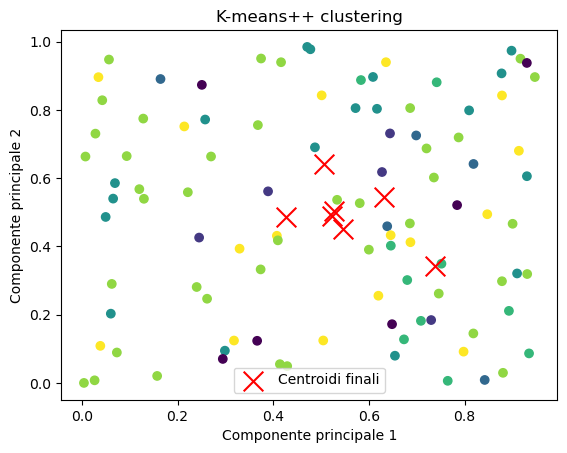

In [ ]:

k = 7  # Numero di cluster

# Eseguiamo K-means++ con MapReduce
centroids, mapped_points = kmeans_plus_plus(df_pca, k)

# Stampa i centroidi finali
print(f"Centroidi finali:\n", centroids)

# (Opzionale) Se vuoi visualizzare i risultati su 2 componenti principali (per visualizzare in 2D)
import matplotlib.pyplot as plt

# Aggiungiamo le etichette (i cluster) ai punti
labels = [centroid_idx for centroid_idx, point in mapped_points]

# Visualizzazione dei dati (su 2D, scegliamo le prime due componenti principali)
plt.scatter(df_pca.iloc[:, 0], df_pca.iloc[:, 1], c=labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', color='red', s=200, label="Centroidi finali")
plt.title("K-means++ clustering")
plt.xlabel("Componente principale 1")
plt.ylabel("Componente principale 2")
plt.legend()
plt.show()



3. Implement the K-means++ algorithm from scratch and apply it to your data. Do you notice any differences between the results obtained using random initialization and those achieved with K-means++? Please explain your observations and discuss why these differences might occur.

In [ ]:
# Funzione per calcolare la distanza Euclidea tra due punti
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

# Funzione per inizializzare i centroidi utilizzando K-means++
def kmeans_plus_plus_init(df, k):
    # Seleziona il primo centroide casualmente
    centroids = [df.sample(n=1).values[0]]
    
    while len(centroids) < k:
        # Calcola la distanza di ogni punto dai centroidi già selezionati
        distances = np.array([min([euclidean_distance(x, c) for c in centroids]) for x in df.values])
        
        # Calcola la probabilità di selezionare un punto come centroide, proporzionale al quadrato della distanza minima
        prob = distances ** 2
        prob = prob / prob.sum()  # Normalizza la probabilità
        
        # Seleziona il nuovo centroide in base alla probabilità calcolata
        new_centroid = df.sample(n=1, weights=prob).values[0]
        centroids.append(new_centroid)
    
    return np.array(centroids)

# Funzione per eseguire il K-means++
def kmeans_plus_plus(df, k, max_iters=100):
    # Inizializza i centroidi usando K-means++
    centroids = kmeans_plus_plus_init(df, k)
    prev_centroids = np.zeros_like(centroids)
    
    # Iterazioni per aggiornare i centroidi
    for i in range(max_iters):
        # Assegna ogni punto al centroide più vicino
        distances = np.array([[euclidean_distance(x, c) for c in centroids] for x in df.values])
        closest_centroids = np.argmin(distances, axis=1)
        
        # Calcola i nuovi centroidi come la media dei punti assegnati a ciascun centroide
        new_centroids = np.array([df.values[closest_centroids == j].mean(axis=0) for j in range(k)])
        
        # Controlla se i centroidi sono cambiati. Se non sono cambiati, termina l'algoritmo
        if np.allclose(new_centroids, centroids):
            print(f"Convergenza raggiunta dopo {i+1} iterazioni.")
            break
        
        centroids = new_centroids
    
    return centroids, closest_centroids



Convergenza raggiunta dopo 2 iterazioni.
Centroidi finali:
[[0.61728175 0.48058578 0.53159739 ... 0.41435577 0.56289744 0.43559952]
 [0.57384762 0.43445626 0.57528233 ... 0.52843934 0.464266   0.58764671]
 [0.50153025 0.49979359 0.57242253 ... 0.51589393 0.57395585 0.55325427]
 ...
 [0.34923521 0.58344632 0.38762434 ... 0.60398921 0.52165026 0.40159211]
 [0.64001984 0.74129031 0.45279593 ... 0.25473322 0.49113436 0.60656989]
 [0.4386831  0.48789382 0.49477794 ... 0.52287846 0.35243155 0.38435253]]
Etichette finali per i punti:
[5 2 2 2 4 0 0 3 2 0]


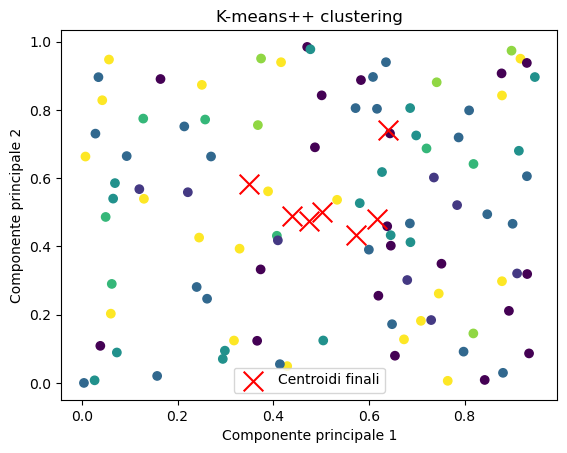

In [ ]:

# Eseguiamo il clustering su df_pca con 7 cluster
# Numero di cluster
k = 7 

# Eseguiamo il K-means++
centroids, labels = kmeans_plus_plus(df_pca, k)

# Visualizza i risultati
print(f"Centroidi finali:\n{centroids}")
print(f"Etichette finali per i punti:\n{labels[:10]}")  # Mostriamo le prime 10 etichette

# (Opzionale) Se vuoi visualizzare i primi 2 componenti principali:
plt.scatter(df_pca.iloc[:, 0], df_pca.iloc[:, 1], c=labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', color='red', s=200, label="Centroidi finali")
plt.title("K-means++ clustering")
plt.xlabel("Componente principale 1")
plt.ylabel("Componente principale 2")
plt.legend()
plt.show()

### **2.4 Best Algorithm**

Clustering helps identify natural groupings within data, but no single algorithm works best for every dataset. In this section, you’ll learn how to choose the most suitable clustering method based on your data’s unique characteristics. By analyzing patterns and comparing results, you’ll uncover which algorithm provides the most meaningful insights and clusters.

1. Set the number of clusters to the optimal number $k_{opt}$ based on any of the methods previously.

2. Select three distinct metrics to assess the quality of the clusters. Describe each metric in detail, including the specific aspects they evaluate to determine the effectiveness of the clustering model.


#### **Silhouette Score:**   $S= \frac{max(a,b)}{b−a} $
 
The *Silhouette Score* measures how well each point is grouped with its cluster and separated from others.
 
Where:

- $a$: mean distance of a point to points in its own cluster.

- $b$: mean distance of a point to points in the nearest neighboring cluster.

- Ranges from −1 to +1 : values near 1 indicate well-separated clusters.

#### **Davies-Bouldin Index**

The *Davies-Bouldin Index (DB)* measures the ratio of intra-cluster distances (cohesion) to inter-cluster distances (separation). A lower DB index indicates better clustering performance.

The formula is defined as:

$$
DB = \frac{1}{k} \sum_{i=1}^{k} \max_{j \neq i} \frac{\sigma_i + \sigma_j}{d(C_i, C_j)}
$$

Where:
- $k$ is the number of clusters.
- $\sigma_i$ is the average distance of all points in cluster $i$ to the centroid of cluster $i$ (cohesion).
- $d(C_i, C_j)$ is the distance between the centroids of clusters $i$ and $j$ (separation).
- The **max** operator ensures that for each cluster $i$, we consider the cluster $j$ with the worst (largest) ratio.


#### **Calinski-Harabasz Index**

The *Calinski-Harabasz Index* is a metric used to evaluate the quality of clustering. 
It assesses the **separation** and **cohesion** of the clusters by comparing the within-cluster dispersion to the between-cluster dispersion. 

The formula is:

$$
CH = \frac{\text{tr}(B_k)}{\text{tr}(W_k)} \times \frac{n - k}{k - 1}
$$

Where:

- $\text{tr}(B_k)$ is the **trace of the between-cluster dispersion matrix**.
- $\text{tr}(W_k)$ is the **trace of the within-cluster dispersion matrix**.
- $n$ is the total number of samples (data points).
- $k$ is the number of clusters.
- *Between-cluster dispersion matrix $B_k$*: Measures the variance between the cluster centroids and the overall centroid.
- *Within-cluster dispersion matrix $W_k$*: Measures the variance within each cluster.

A **higher** value of the Calinski-Harabasz index indicates better clustering performance, meaning the clusters are more distinct and more cohesive.

3. Apply the three clustering algorithms used in the prior section to partition the data into $k_{opt}$ clusters. Then, evaluate each model's clustering quality using the selected metrics. Summarize your findings by comparing the results of each algorithm based on the metric evaluations.


## **Bonus Question**
___
K-means is an iterative algorithm, meaning that with each iteration, it refines the clusters by adjusting them based on the distance of each data point relative to the center of each cluster. This process continues until it reaches a point of convergence or hits a set limit on the number of iterations. You might want to track the progress of forming your clusters.

1. Select two variables from your instances to display them on a 2D plot. Then, illustrate the progression of the clusters as they change at each iteration. We expect a plot for each iteration, displaying the instances and the clusters they belong to. Select the two features that most effectively separate visual instances belonging to different clusters. Explain the method you used to determine these features.

## **4. Algorithmic Question**

Two brilliant strategists, Arya and Mario, are about to play a game with a sequence of numbers. Arya, as player 1, begins the game, while Mario, player 2, plays 2nd. Their goal is clear: to collect the highest possible score by taking numbers from either end of the sequence, one at a time. They will play in perfect synchronicity, each seeking the advantage.

The sequence represented as an array of `nums`, is laid out in front of them. Arya will start by selecting either the number at the beginning (`nums[0]`) or the end (`nums[nums.length - 1]`) of the array, adding that value to her score. This value is then removed from the beginning or the end of `nums`. Then, it’s Mario’s turn to do the same with the remaining sequence. The game proceeds this way, with each player taking numbers from either end until no numbers are left to claim. The player with the highest score wins.

However, if they end in a tie, Arya, as the first to act, will claim victory by default.

Arya is now before you, asking for help to predict her chances. She wants to know, with her best possible choices, whether she can guarantee a win, assuming both players play with perfect skill.



- a) Help Arya by providing a pseudocode for finding an optimal playing strategy, that is, a strategy that maximizes her value. (Hint: Use recursion, assuming that both players play optimally).



- b) Write a Python program implementing her game strategy. Try different array lengths to test the algorithm.



- c) Is the algorithm efficient? Prove that it is polynomial and provide an asymptotic time complexity bound, or show that it requires exponential time.



- d) If the algorithm is exponential, explain how to make it polynomial and provide a pseudocode for it. Recompute the computational complexity of the updated algorithm.



- e) Implement the algorithm in Python. Compare your result values with the previous algorithm. Also compare the running times.



- f) Finally, consult LLM (ChatGPT, Claude AI, Gemini, Perplexity, etc.) to craft a third, optimized implementation and analyze its time complexity. Also, explain if the LLM is doing a good job and how you can evaluate whether the suggested solution works properly.